In [3]:
import pandas as pd
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import problem
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from typing import Dict, Any, Tuple

# Lecture des données

In [4]:
train_participants = pd.read_csv("data/train_participants.csv")

In [5]:
train_rois = pd.read_csv("data/train_rois.csv")
test_rois = pd.read_csv("data/test_rois.csv")
train_rois.shape

(410, 291)

In [6]:
X_train, y_train = problem.get_train_data(path=".", datatype=["rois"])
X_test, y_test = problem.get_test_data(path=".", datatype=["rois"])

assert X_train.shape[1] == 284 

# Catégorisation des variables en 4 zones cérébrales

1. **Le cortex cérébral** : Le cortex cérébral est la couche externe du cerveau, composée de matière grise. Il est responsable des fonctions cognitives supérieures telles que la perception, la mémoire, la prise de décision, le langage, et la motricité. Il est divisé en plusieurs régions spécialisées, comme le cortex frontal, occipital, temporal et pariétal.

2. **Les structures sous-corticales** : Les structures sous-corticales se trouvent sous le cortex cérébral et incluent des régions telles que les noyaux basaux, l'amygdale, l'hippocampe et le thalamus. Ces structures sont impliquées dans la régulation des mouvements, la mémoire, les émotions, et diverses fonctions autonomes comme la gestion de la douleur et la perception sensorielle.

3. **Le tronc cérébral** : Le tronc cérébral est la partie inférieure du cerveau qui relie le cerveau à la moelle épinière. Il est constitué du mésencéphale, du pont et de la moelle allongée. Il régule des fonctions vitales telles que la respiration, le rythme cardiaque, la pression artérielle et le sommeil. Il joue également un rôle dans la transmission des informations sensorielles et motrices.

4. **Le cervelet** : Le cervelet est situé à l'arrière du cerveau, sous les hémisphères cérébraux. Il est principalement impliqué dans la coordination des mouvements, l'équilibre et la précision motrice. Il reçoit des informations sensorielles et motrices et ajuste la motricité fine pour garantir des mouvements fluides et harmonieux.

In [7]:
cortex_cerebral_GM = ["lAntIns_GM_Vol", "rAntIns_GM_Vol" ,
                "lAntOrbGy_GM_Vol", "rAntOrbGy_GM_Vol" ,
                "lFroOpe_GM_Vol", "rFroOpe_GM_Vol" ,
                "lFroPo_GM_Vol", "rFroPo_GM_Vol" ,
                "lMidFroGy_GM_Vol", "rMidFroGy_GM_Vol" ,
                "lMedFroCbr_GM_Vol", "rMedFroCbr_GM_Vol" ,
                "lSupMedFroGy_GM_Vol", "rSupMedFroGy_GM_Vol" ,
                "lInfFroGy_GM_Vol", "rInfFroGy_GM_Vol" ,
                "lInfFroOrbGy_GM_Vol", "rInfFroOrbGy_GM_Vol" ,
                "lSupFroGy_GM_Vol", "rSupFroGy_GM_Vol" ,
                "lInfFroAngGy_GM_Vol", "rInfFroAngGy_GM_Vol", 
                "lAngGy_GM_Vol", "rAngGy_GM_Vol",
                "lCun_GM_Vol", "rCun_GM_Vol" ,
                "lInfOccGy_GM_Vol", "rInfOccGy_GM_Vol" ,
                "lMidOccGy_GM_Vol", "rMidOccGy_GM_Vol" ,
                "lOccPo_GM_Vol", "rOccPo_GM_Vol" ,
                "lPCu_GM_Vol", "rPCu_GM_Vol" ,
                "lParHipGy_GM_Vol", "rParHipGy_GM_Vol" ,
                "lParOpe_GM_Vol", "rParOpe_GM_Vol" ,
                "lPoCGy_GM_Vol", "rPoCGy_GM_Vol" ,
                "lSupParLo_GM_Vol", "rSupParLo_GM_Vol" ,
                "lOccFusGy_GM_Vol", "rOccFusGy_GM_Vol" ,
                "lPosOrbGy_GM_Vol", "rPosOrbGy_GM_Vol",
                "lSupOccGy_GM_Vol", "rSupOccGy_GM_Vol", 
                "lEnt_GM_Vol", "rEnt_GM_Vol" ,
                "lFusGy_GM_Vol", "rFusGy_GM_Vol" ,
                "lInfTemGy_GM_Vol", "rInfTemGy_GM_Vol" ,
                "lMidTemGy_GM_Vol", "rMidTemGy_GM_Vol" ,
                "lTem_GM_Vol", "rTem_GM_Vol" ,
                "lTemPo_GM_Vol", "rTemPo_GM_Vol" ,
                "lTemTraGy_GM_Vol", "rTemTraGy_GM_Vol" ,
                "lPosIns_GM_Vol", "rPosIns_GM_Vol",
                "lPosCinGy_GM_Vol", "rPosCinGy_GM_Vol" ,
                "lCenOpe_GM_Vol", "rCenOpe_GM_Vol",
                "lCal+Cbr_GM_Vol", "rCal+Cbr_GM_Vol",
                "lRecGy_GM_Vol", "rRecGy_GM_Vol" ,
                "lLinGy_GM_Vol", "rLinGy_GM_Vol" ,
                "lLatOrbGy_GM_Vol", "rLatOrbGy_GM_Vol" ,
                "lMidCinGy_GM_Vol", "rMidCinGy_GM_Vol" ,
                "lMedOrbGy_GM_Vol", "rMedOrbGy_GM_Vol" ,
                "lMedPoCGy_GM_Vol", "rMedPoCGy_GM_Vol" ,
                "lMedPrcGy_GM_Vol", "rMedPrcGy_GM_Vol" ,
                "lPrcGy_GM_Vol", "rPrcGy_GM_Vol" ,
                "lPla_GM_Vol", "rPla_GM_Vol" ,
                "lSCA_GM_Vol", "rSCA_GM_Vol" ,
                "lSupMarGy_GM_Vol", "rSupMarGy_GM_Vol", 
                "lAntCinGy_GM_Vol", "rAntCinGy_GM_Vol", 
                "lOC_GM_Vol", "rOC_GM_Vol"]

cortex_cerebral_CSF = ["lCenOpe_CSF_Vol", "rCenOpe_CSF_Vol" ,
                "lFroOpe_CSF_Vol", "rFroOpe_CSF_Vol" ,
                "lFroPo_CSF_Vol", "rFroPo_CSF_Vol",
                "lMidFroGy_CSF_Vol", "rMidFroGy_CSF_Vol" ,
                "lMedFroCbr_CSF_Vol", "rMedFroCbr_CSF_Vol" ,
                "lSupMedFroGy_CSF_Vol", "rSupMedFroGy_CSF_Vol" ,
                "lLatOrbGy_CSF_Vol", "rLatOrbGy_CSF_Vol" ,
                "lMedOrbGy_CSF_Vol", "rMedOrbGy_CSF_Vol" ,
                "lInfFroGy_CSF_Vol", "rInfFroGy_CSF_Vol" ,
                "lInfFroOrbGy_CSF_Vol", "rInfFroOrbGy_CSF_Vol" ,
                "lPosIns_CSF_Vol", "rPosIns_CSF_Vol" ,
                "lSupFroGy_CSF_Vol", "rSupFroGy_CSF_Vol" ,
                "lInfFroAngGy_CSF_Vol", "rInfFroAngGy_CSF_Vol" ,
                "lPrcGy_CSF_Vol", "rPrcGy_CSF_Vol", 
                "lInfOccGy_CSF_Vol", "rInfOccGy_CSF_Vol" ,
                "lMidOccGy_CSF_Vol", "rMidOccGy_CSF_Vol" ,
                "lOccPo_CSF_Vol", "rOccPo_CSF_Vol" ,
                "lOccFusGy_CSF_Vol", "rOccFusGy_CSF_Vol" ,
                "lCun_CSF_Vol", "rCun_CSF_Vol" ,
                "lPosCinGy_CSF_Vol", "rPosCinGy_CSF_Vol" ,
                "lPCu_CSF_Vol", "rPCu_CSF_Vol" ,
                "lPoCGy_CSF_Vol", "rPoCGy_CSF_Vol" ,
                "lParOpe_CSF_Vol", "rParOpe_CSF_Vol" ,
                "lSupParLo_CSF_Vol", "rSupParLo_CSF_Vol" ,
                "lSupOccGy_CSF_Vol", "rSupOccGy_CSF_Vol" ,
                "lPosOrbGy_CSF_Vol", "rPosOrbGy_CSF_Vol" ,
                "lInfTemGy_CSF_Vol", "rInfTemGy_CSF_Vol" ,
                "lMidTemGy_CSF_Vol", "rMidTemGy_CSF_Vol" ,
                "lEnt_CSF_Vol", "rEnt_CSF_Vol" ,
                "lParHipGy_CSF_Vol", "rParHipGy_CSF_Vol" ,
                "lTem_CSF_Vol", "rTem_CSF_Vol" ,
                "lSupTemGy_CSF_Vol", "rSupTemGy_CSF_Vol" ,
                "lTemPo_CSF_Vol", "rTemPo_CSF_Vol" ,
                "lTemTraGy_CSF_Vol", "rTemTraGy_CSF_Vol" ,
                "lOC_CSF_Vol", "rOC_CSF_Vol" ,
                "lAntCinGy_CSF_Vol", "rAntCinGy_CSF_Vol" ,
                "lAntIns_CSF_Vol", "rAntIns_CSF_Vol" ,
                "lAntOrbGy_CSF_Vol", "rAntOrbGy_CSF_Vol" ,
                "lAngGy_CSF_Vol", "rAngGy_CSF_Vol" ,
                "lCal+Cbr_CSF_Vol", "rCal+Cbr_CSF_Vol"]

structures_sous_corticales_GM = ["lAcc_GM_Vol", "rAcc_GM_Vol" ,
                "lAmy_GM_Vol", "rAmy_GM_Vol" ,
                "lBst_GM_Vol", "rBst_GM_Vol" ,
                "lCau_GM_Vol", "rCau_GM_Vol" ,
                "lPal_GM_Vol", "rPal_GM_Vol" ,
                "lPut_GM_Vol", "rPut_GM_Vol" ,
                "lThaPro_GM_Vol", "rThaPro_GM_Vol", 
                "lBasCbr+FobBr_GM_Vol", "rBasCbr+FobBr_GM_Vol"]

structures_sous_corticales_CSF = ["lAcc_CSF_Vol", "rAcc_CSF_Vol" ,
                "lAmy_CSF_Vol", "rAmy_CSF_Vol" ,
                "lBst_CSF_Vol", "rBst_CSF_Vol" ,
                "lCau_CSF_Vol", "rCau_CSF_Vol" ,
                "lPal_CSF_Vol", "rPal_CSF_Vol" ,
                "lPut_CSF_Vol", "rPut_CSF_Vol" ,
                "lThaPro_CSF_Vol", "rThaPro_CSF_Vol" ,
                "lLinGy_CSF_Vol", "rLinGy_CSF_Vol" ,
                "lMidCinGy_CSF_Vol", "rMidCinGy_CSF_Vol" ,
                "lMedPoCGy_CSF_Vol", "rMedPoCGy_CSF_Vol" ,
                "lMedPrcGy_CSF_Vol", "rMedPrcGy_CSF_Vol" ,
                "lFusGy_CSF_Vol", "rFusGy_CSF_Vol" ,
                "lRecGy_CSF_Vol", "rRecGy_CSF_Vol", 
                "lBasCbr+FobBr_CSF_Vol", "rBasCbr+FobBr_CSF_Vol", 
                "lPla_CSF_Vol", "rPla_CSF_Vol", 
                "lSCA_CSF_Vol", "rSCA_CSF_Vol", 
                "lCbr+Mot_CSF_Vol", "rCbr+Mot_CSF_Vol", 
                "lSupMarGy_CSF_Vol", "rSupMarGy_CSF_Vol"]

tronc_cerebral_GM = ["l3thVen_GM_Vol", "r3thVen_GM_Vol" ,
                "l4thVen_GM_Vol", "r4thVen_GM_Vol" ,
                "lInfLatVen_GM_Vol", "rInfLatVen_GM_Vol" ,
                "lLatVen_GM_Vol", "rLatVen_GM_Vol" ,
                "lVenVen_GM_Vol", "rVenVen_GM_Vol"]
                
tronc_cerebral_CSF = ["l3thVen_CSF_Vol", "r3thVen_CSF_Vol" ,
                "l4thVen_CSF_Vol", "r4thVen_CSF_Vol" ,
                "lCSF_CSF_Vol", "rCSF_CSF_Vol" ,
                "lInfLatVen_CSF_Vol", "rInfLatVen_CSF_Vol" ,
                "lLatVen_CSF_Vol", "rLatVen_CSF_Vol" ,
                "lVenVen_CSF_Vol", "rVenVen_CSF_Vol"]

cervelet_GM = ["lExtCbe_GM_Vol", "rExtCbe_GM_Vol" ,
                "lCbeWM_GM_Vol", "rCbeWM_GM_Vol" ,
                "lCbeLoCbe1-5_GM_Vol", "rCbeLoCbe1-5_GM_Vol" ,
                "lCbeLoCbe6-7_GM_Vol", "rCbeLoCbe6-7_GM_Vol" ,
                "lCbeLoCbe8-10_GM_Vol", "rCbeLoCbe8-10_GM_Vol"]

cervelet_CSF = ["lExtCbe_CSF_Vol", "rExtCbe_CSF_Vol", 
                "lCbeLoCbe1-5_CSF_Vol", "rCbeLoCbe1-5_CSF_Vol",
                "lCbeLoCbe6-7_CSF_Vol", "rCbeLoCbe6-7_CSF_Vol",
                "lCbeLoCbe8-10_CSF_Vol", "rCbeLoCbe8-10_CSF_Vol"]
                
autre_GM = ["lCbr+Mot_GM_Vol", 
               "rCbr+Mot_GM_Vol","lCbrWM_GM_Vol",
               "rCbrWM_GM_Vol",
               "lCSF_GM_Vol",
               "rCSF_GM_Vol",
               "lHip_GM_Vol",
               "rHip_GM_Vol",
               "lSupTemGy_GM_Vol",
               "rSupTemGy_GM_Vol"]

autre_CSF = ["lCbeWM_CSF_Vol", "rCbeWM_CSF_Vol" ,
               "lCbrWM_CSF_Vol", "rCbrWM_CSF_Vol", "lHip_CSF_Vol",
               "rHip_CSF_Vol"]


In [8]:
assert len(cortex_cerebral_GM) + len(cortex_cerebral_CSF) + len(structures_sous_corticales_GM) + len(structures_sous_corticales_CSF) + len(tronc_cerebral_GM) + len(tronc_cerebral_CSF) + len(cervelet_GM) + len(cervelet_CSF) + len(autre_GM) + len(autre_CSF) == train_rois.shape[1] - 7

# Calcul du volume total pour les 5 nouvelles variables créées

In [9]:
zones = [
    (cortex_cerebral_GM, cortex_cerebral_CSF, "cortex_cerebral"),
    (structures_sous_corticales_GM, structures_sous_corticales_CSF, "structures_sous_corticales"),
    (tronc_cerebral_GM, tronc_cerebral_CSF, "tronc_cerebral"),
    (cervelet_GM, cervelet_CSF, "cervelet"),
    (autre_GM, autre_CSF, "autre")
]

for zone_GM, zone_CSF, zone in zones:
    train_rois[f"Vol_GM_{zone}"] = train_rois[zone_GM].sum(axis=1)
    train_rois[f"Vol_CSF_{zone}"] = train_rois[zone_CSF].sum(axis=1)

for zone_GM, zone_CSF, zone in zones:
    test_rois[f"Vol_GM_{zone}"] = test_rois[zone_GM].sum(axis=1)
    test_rois[f"Vol_CSF_{zone}"] = test_rois[zone_CSF].sum(axis=1)


# Test de normalité des données

In [10]:
from scipy.stats import shapiro

# Filtrer pour ne garder que les colonnes numériques
numerical_columns = train_rois.select_dtypes(include=['number']).columns

# Effectuer le test de Shapiro-Wilk pour chaque colonne numérique
for col in numerical_columns:
    stat, p_value = shapiro(train_rois[col])
    print(f"Shapiro-Wilk Test for {col}: Statistics={stat:.4f}, p-value={p_value:.4f}")
    
    if p_value > 0.05:
        print(f"{col} semble suivre une distribution normale (p-value > 0.05)\n")
    else:
        print(f"{col} ne semble pas suivre une distribution normale (p-value <= 0.05)\n")


d:\bureau\M2 MOSEF\S1\ML\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for run: Statistics=1.0000, p-value=1.0000
run semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for TIV: Statistics=0.9959, p-value=0.3647
TIV semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for CSF_Vol: Statistics=0.9615, p-value=0.0000
CSF_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for GM_Vol: Statistics=0.9940, p-value=0.1093
GM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for WM_Vol: Statistics=0.9930, p-value=0.0542
WM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for l3thVen_GM_Vol: Statistics=0.9477, p-value=0.0000
l3thVen_GM_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for r3thVen_GM_Vol: Statistics=0.9721, p-value=0.0000
r3thVen_GM_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for l4thVen_GM_Vol: Statistics=0.9480, p

# Normalisation des données

In [11]:
train_rois = train_rois.drop(train_rois.columns[:4], axis=1)
test_rois = test_rois.drop(test_rois.columns[:4], axis=1)

In [12]:
scaler = MinMaxScaler()
train_rois_scaled = scaler.fit_transform(train_rois)
test_rois_scaled = scaler.transform(test_rois)

# Encodage de la cible

In [13]:
# Remplacez les valeurs directement
y_train = np.where(y_train == 'schizophrenia', 1, 0)
y_test = np.where(y_test == 'schizophrenia', 1, 0)

# Modélisation

In [14]:
class ModelOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, random_state=42):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.random_state = random_state
        
        self.param_spaces = {
            'l1_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l1'],
                'solver': ['liblinear'],
                'max_iter': ('int', 1000, 5000)
            },
            'l2_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l2'],
                'solver': ['lbfgs'],
                'max_iter': ('int', 1000, 5000)
            },
            'EN_logreg': {
                'C': ('float', 1e-6, 0.1, True),  
                'solver': ['saga'],
                'max_iter': ('int', 1000, 5000),
                'penalty': ['elasticnet'],
                'l1_ratio': ('float', 0.3, 0.7)
            },
            'svc': {
                'C': ('float', 1e-6, 0.1, True),  
                'kernel': ['rbf'],
                'gamma': ('float', 1e-6, 1e-3, True)  
            },
            'knn': {
                'n_neighbors': ('int', 10, 20),  
                'weights': ['uniform'],
                'p': ('int', 2, 2),
                'leaf_size': ('int', 30, 40)  
            },
            'gbc': {
                'n_estimators': ('int', 50, 100),
                'learning_rate': ('float', 1e-5, 1e-3, True),  
                'max_depth': ('int', 2, 5),  
                'subsample': ('float', 0.5, 0.8),  
                'min_samples_split': ('int', 10, 20),  
                'min_samples_leaf': ('int', 5, 10),  
                'max_features': ('float', 0.3, 0.5)  
            },
            'rf': {  
                'n_estimators': ('int', 50, 100),  
                'max_depth': ('int', 5, 20),  
                'min_samples_split': ('int', 5, 10),  
                'min_samples_leaf': ('int', 2, 5),  
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False]
            }
        }

    def _suggest_parameters(self, trial: optuna.Trial, model_name: str) -> Dict[str, Any]:
        
        params = {}
        space = self.param_spaces[model_name]
        
        for param_name, param_config in space.items():
            if isinstance(param_config, list):
                params[param_name] = trial.suggest_categorical(param_name, param_config)
            else:
                param_type, low, high, *log = param_config
                if param_type == 'int':
                    params[param_name] = trial.suggest_int(param_name, low, high)
                elif param_type == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name, low, high, 
                        log=log[0] if log else False
                    )
        
        return params

    def _get_model(self, model_name: str, params: Dict[str, Any]) -> Any:
        
        if model_name in ['l1_logreg', 'l2_logreg', 'EN_logreg']:
           
            if 'penalty' in params:
                penalty = params.pop('penalty')
            l1_ratio = params.pop('l1_ratio', None)
            
            if model_name == 'l1_logreg':
                return LogisticRegression(
                    penalty='l1',
                    **params,
                    random_state=self.random_state
                )
            elif model_name == 'l2_logreg':
                return LogisticRegression(
                    penalty='l2',
                    **params,
                    random_state=self.random_state
                )
            else:
                return LogisticRegression(
                    penalty='elasticnet',
                    l1_ratio=l1_ratio,
                    **params,
                    random_state=self.random_state
                )
        
        models = {
            'svc': lambda **params: SVC(**params, probability=True, random_state=self.random_state),
            'knn': KNeighborsClassifier,
            'gbc': lambda **params: GradientBoostingClassifier(**params, random_state=self.random_state),
            'rf': lambda **params: RandomForestClassifier(**params, random_state=self.random_state)
        }
        
        return models[model_name](**params)

    def optimize_model(self, model_name: str, n_trials: int = 50) -> Tuple[Any, Dict[str, Any], float]:
        """Optimise les hyperparamètres avec validation croisée."""
        def objective(trial):
            params = self._suggest_parameters(trial, model_name)
            model = self._get_model(model_name, params)
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
            
            scores = cross_val_score(
                model, self.X_train, self.y_train, 
                cv=cv, scoring='roc_auc', n_jobs=-1
            )
            
            return np.mean(scores) - 0.5 * np.std(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_trial.params
        best_model = self._get_model(model_name, best_params)
        best_score = study.best_value

        return best_model, best_params, best_score

    def evaluate_model(self, model: Any) -> Tuple[float, float]:
        model.fit(self.X_train, self.y_train)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        train_scores = []
        test_scores = []
        
        for train_idx, val_idx in cv.split(self.X_train, self.y_train):
            X_train_cv, X_val_cv = self.X_train[train_idx], self.X_train[val_idx]
            y_train_cv, y_val_cv = self.y_train[train_idx], self.y_train[val_idx]

            
            model.fit(X_train_cv, y_train_cv)
            
            train_scores.append(roc_auc_score(
                y_train_cv,
                model.predict_proba(X_train_cv)[:, 1]
            ))
            test_scores.append(roc_auc_score(
                y_val_cv,
                model.predict_proba(X_val_cv)[:, 1]
            ))
        
        return np.mean(train_scores), np.mean(test_scores)

def main(X_train, X_test, y_train, y_test):
    optimizer = ModelOptimizer(X_train, X_test, y_train, y_test)
    models = ['l1_logreg', 'l2_logreg', 'EN_logreg', 'svc', 'knn', 'gbc', 'rf']
    results = {}
    comparison_data = []
    
    for model_name in models:
        print(f"\nOptimisation de {model_name}...")

        best_model, best_params, cv_score = optimizer.optimize_model(model_name)
        train_auc, val_auc = optimizer.evaluate_model(best_model)

        best_model.fit(optimizer.X_train, optimizer.y_train)
        test_auc = roc_auc_score(
            optimizer.y_test,
            best_model.predict_proba(optimizer.X_test)[:, 1]
        )

        overfitting_rate = ((train_auc - test_auc) / train_auc) * 100

        print(f"Meilleurs hyperparamètres pour {model_name}: {best_params}")
        print(f"Meilleur score (CV AUC) pour {model_name}: {cv_score:.4f}")

        model_display_names = {
            'l1_logreg': 'Régression Logistique L1 (Lasso)',
            'l2_logreg': 'Régression Logistique L2 (Ridge)',
            'EN_logreg': 'Régression Logistique (Elastic Net)',
            'svc': 'SVM',
            'knn': 'k-NN',
            'gbc': 'Gradient Boosting',
            'rf': 'Random Forest'
        }

        comparison_data.append({
            'Modèle': model_display_names[model_name],
            'Train AUC': train_auc,
            'CV AUC': cv_score,
            'Validation AUC': val_auc,
            'Test AUC': test_auc,
            'Overfitting (%)': overfitting_rate
        })

        results[model_name] = {
            'model': best_model,
            'params': best_params,
            'metrics': {
                'train_auc': train_auc,
                'cv_auc': cv_score,
                'val_auc': val_auc,
                'test_auc': test_auc,
                'overfitting_rate': overfitting_rate
            }
        }

  
    df = pd.DataFrame(comparison_data)
    df = df.set_index('Modèle')


    for col in ['Train AUC', 'CV AUC', 'Validation AUC', 'Test AUC']:
        df[col] = df[col].map('{:.4f}'.format)
    df['Overfitting (%)'] = df['Overfitting (%)'].map('{:.2f}'.format)


    print("\n" + "="*90)
    print(" "*35 + "TABLEAU COMPARATIF DES MODÈLES")
    print("="*90)

 
    table_str = df.to_string()
    lines = table_str.split('\n')
    width = len(lines[0])
    separator = '-' * width

    print(separator)
    print(lines[0])  
    print(separator)
    for line in lines[1:]:
        print(line)
    print(separator)


    best_model_idx = df['Test AUC'].astype(float).idxmax()
    print(f"\nMeilleur modèle: {best_model_idx}")
    print(f"Score CV: {df.loc[best_model_idx, 'CV AUC']}")
    print(f"Score de test: {df.loc[best_model_idx, 'Test AUC']}")
    print(f"Taux d'overfitting: {df.loc[best_model_idx, 'Overfitting (%)']}%")

    return results, df

if __name__ == "__main__":
    results, comparison_df = main(train_rois_scaled, test_rois_scaled, y_train, y_test)


[I 2025-01-19 21:43:06,076] A new study created in memory with name: no-name-d0f0974e-f0a8-4f99-88c1-49286b66e266



Optimisation de l1_logreg...


[I 2025-01-19 21:43:15,347] Trial 0 finished with value: 0.5 and parameters: {'C': 0.0341604666287921, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 2472}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:15,506] Trial 1 finished with value: 0.5 and parameters: {'C': 0.00043913916206555635, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4333}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:15,613] Trial 2 finished with value: 0.5 and parameters: {'C': 7.270922849739921e-06, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 2870}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:15,725] Trial 3 finished with value: 0.5 and parameters: {'C': 9.406781478624804e-05, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 3073}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:15,797] Trial 4 finished with value: 0.5 and parameters: {'C': 1.4193404729601095e-06, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4364}. Best is trial 0 with value: 0.5.
[I 2025-01-

Meilleurs hyperparamètres pour l1_logreg: {'C': 0.09938569721238456, 'solver': 'liblinear', 'max_iter': 2809}
Meilleur score (CV AUC) pour l1_logreg: 0.6557

Optimisation de l2_logreg...


[I 2025-01-19 21:43:24,274] Trial 1 finished with value: 0.6690565354417737 and parameters: {'C': 2.37034390619184e-06, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2186}. Best is trial 0 with value: 0.6690682327909702.
[I 2025-01-19 21:43:24,441] Trial 2 finished with value: 0.6848253203689983 and parameters: {'C': 0.003944715202782423, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3851}. Best is trial 2 with value: 0.6848253203689983.
[I 2025-01-19 21:43:24,587] Trial 3 finished with value: 0.6689075861530654 and parameters: {'C': 2.245626219165544e-06, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3749}. Best is trial 2 with value: 0.6848253203689983.
[I 2025-01-19 21:43:24,706] Trial 4 finished with value: 0.6689905915029035 and parameters: {'C': 3.0794395862748394e-05, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 4819}. Best is trial 2 with value: 0.6848253203689983.
[I 2025-01-19 21:43:24,867] Trial 5 finished with value: 0.6695211415676402 and parameters: {'C': 0.00012

Meilleurs hyperparamètres pour l2_logreg: {'C': 0.09946581313000616, 'solver': 'lbfgs', 'max_iter': 1631}
Meilleur score (CV AUC) pour l2_logreg: 0.7723

Optimisation de EN_logreg...


[I 2025-01-19 21:43:33,310] Trial 1 finished with value: 0.5 and parameters: {'C': 4.591226585258701e-05, 'solver': 'saga', 'max_iter': 3703, 'penalty': 'elasticnet', 'l1_ratio': 0.32385590981800405}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:33,411] Trial 2 finished with value: 0.5 and parameters: {'C': 0.021184079112136222, 'solver': 'saga', 'max_iter': 3391, 'penalty': 'elasticnet', 'l1_ratio': 0.6012512871669027}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:33,490] Trial 3 finished with value: 0.5 and parameters: {'C': 2.845683163292936e-05, 'solver': 'saga', 'max_iter': 1401, 'penalty': 'elasticnet', 'l1_ratio': 0.5878268945706127}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:33,551] Trial 4 finished with value: 0.5 and parameters: {'C': 0.00033999621575489037, 'solver': 'saga', 'max_iter': 4858, 'penalty': 'elasticnet', 'l1_ratio': 0.44745002439699294}. Best is trial 0 with value: 0.5.
[I 2025-01-19 21:43:34,415] Trial 5 finished with value: 0.7229485

Meilleurs hyperparamètres pour EN_logreg: {'C': 0.09910215869467025, 'solver': 'saga', 'max_iter': 1894}
Meilleur score (CV AUC) pour EN_logreg: 0.7472

Optimisation de svc...


[I 2025-01-19 21:44:04,776] Trial 0 finished with value: 0.6863498235746985 and parameters: {'C': 1.6512763789763728e-06, 'kernel': 'rbf', 'gamma': 6.542601928343496e-05}. Best is trial 0 with value: 0.6863498235746985.
[I 2025-01-19 21:44:05,584] Trial 1 finished with value: 0.6858789097603446 and parameters: {'C': 0.001305760794406802, 'kernel': 'rbf', 'gamma': 0.00047479886951548334}. Best is trial 0 with value: 0.6863498235746985.
[I 2025-01-19 21:44:06,241] Trial 2 finished with value: 0.6861357572652944 and parameters: {'C': 0.0001673754050368798, 'kernel': 'rbf', 'gamma': 0.00019947485347206022}. Best is trial 0 with value: 0.6863498235746985.
[I 2025-01-19 21:44:06,943] Trial 3 finished with value: 0.6855398844569225 and parameters: {'C': 0.0007540692761835255, 'kernel': 'rbf', 'gamma': 1.8105852720381356e-06}. Best is trial 0 with value: 0.6863498235746985.
[I 2025-01-19 21:44:07,655] Trial 4 finished with value: 0.6863498235746985 and parameters: {'C': 0.005335407497465017, '

Meilleurs hyperparamètres pour svc: {'C': 5.666568870462682e-06, 'kernel': 'rbf', 'gamma': 2.786584208662807e-06}
Meilleur score (CV AUC) pour svc: 0.6870

Optimisation de knn...


[I 2025-01-19 21:44:52,302] Trial 0 finished with value: 0.7191824762466821 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2, 'leaf_size': 33}. Best is trial 0 with value: 0.7191824762466821.
[I 2025-01-19 21:44:52,482] Trial 1 finished with value: 0.738048005174349 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 32}. Best is trial 1 with value: 0.738048005174349.
[I 2025-01-19 21:44:52,586] Trial 2 finished with value: 0.7324201551168696 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2, 'leaf_size': 36}. Best is trial 1 with value: 0.738048005174349.
[I 2025-01-19 21:44:52,697] Trial 3 finished with value: 0.7096757440952017 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2, 'leaf_size': 40}. Best is trial 1 with value: 0.738048005174349.
[I 2025-01-19 21:44:52,825] Trial 4 finished with value: 0.7073993341666684 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2, 'leaf_size': 36}. Best is tria

Meilleurs hyperparamètres pour knn: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 32}
Meilleur score (CV AUC) pour knn: 0.7380

Optimisation de gbc...


[I 2025-01-19 21:45:11,018] Trial 0 finished with value: 0.7673665022238721 and parameters: {'n_estimators': 82, 'learning_rate': 0.00011157297824533109, 'max_depth': 5, 'subsample': 0.697466717349418, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.47523299152670495}. Best is trial 0 with value: 0.7673665022238721.
[I 2025-01-19 21:45:15,672] Trial 1 finished with value: 0.7603940514905307 and parameters: {'n_estimators': 66, 'learning_rate': 2.3042565492439036e-05, 'max_depth': 3, 'subsample': 0.709355514308945, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 0.33351406164677083}. Best is trial 0 with value: 0.7673665022238721.
[I 2025-01-19 21:45:20,848] Trial 2 finished with value: 0.734993194156868 and parameters: {'n_estimators': 79, 'learning_rate': 7.974115936738646e-05, 'max_depth': 2, 'subsample': 0.7590862791002554, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 0.3766702967445156}. Best is trial 0 with value: 0.76736650222

Meilleurs hyperparamètres pour gbc: {'n_estimators': 60, 'learning_rate': 0.00025766737503979707, 'max_depth': 5, 'subsample': 0.725429513366362, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 0.38418592071605107}
Meilleur score (CV AUC) pour gbc: 0.7799

Optimisation de rf...


[I 2025-01-19 21:50:11,940] Trial 0 finished with value: 0.7452245007063037 and parameters: {'n_estimators': 57, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.7452245007063037.
[I 2025-01-19 21:50:14,010] Trial 1 finished with value: 0.7389378701611591 and parameters: {'n_estimators': 51, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7452245007063037.
[I 2025-01-19 21:50:19,016] Trial 2 finished with value: 0.7604010793813535 and parameters: {'n_estimators': 91, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.7604010793813535.
[I 2025-01-19 21:50:20,843] Trial 3 finished with value: 0.7382360145815637 and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features':

Meilleurs hyperparamètres pour rf: {'n_estimators': 62, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Meilleur score (CV AUC) pour rf: 0.7771

                                   TABLEAU COMPARATIF DES MODÈLES
---------------------------------------------------------------------------------------------
                                    Train AUC  CV AUC Validation AUC Test AUC Overfitting (%)
---------------------------------------------------------------------------------------------
Modèle                                                                                       
Régression Logistique L1 (Lasso)       0.7223  0.6557         0.6871   0.7080            1.99
Régression Logistique L2 (Ridge)       0.8648  0.7723         0.8056   0.8110            6.22
Régression Logistique (Elastic Net)    0.8219  0.7472         0.7872   0.7951            3.26
SVM                                    0.7491  0.6870         0.7394   

# Importances des variables par SHAP

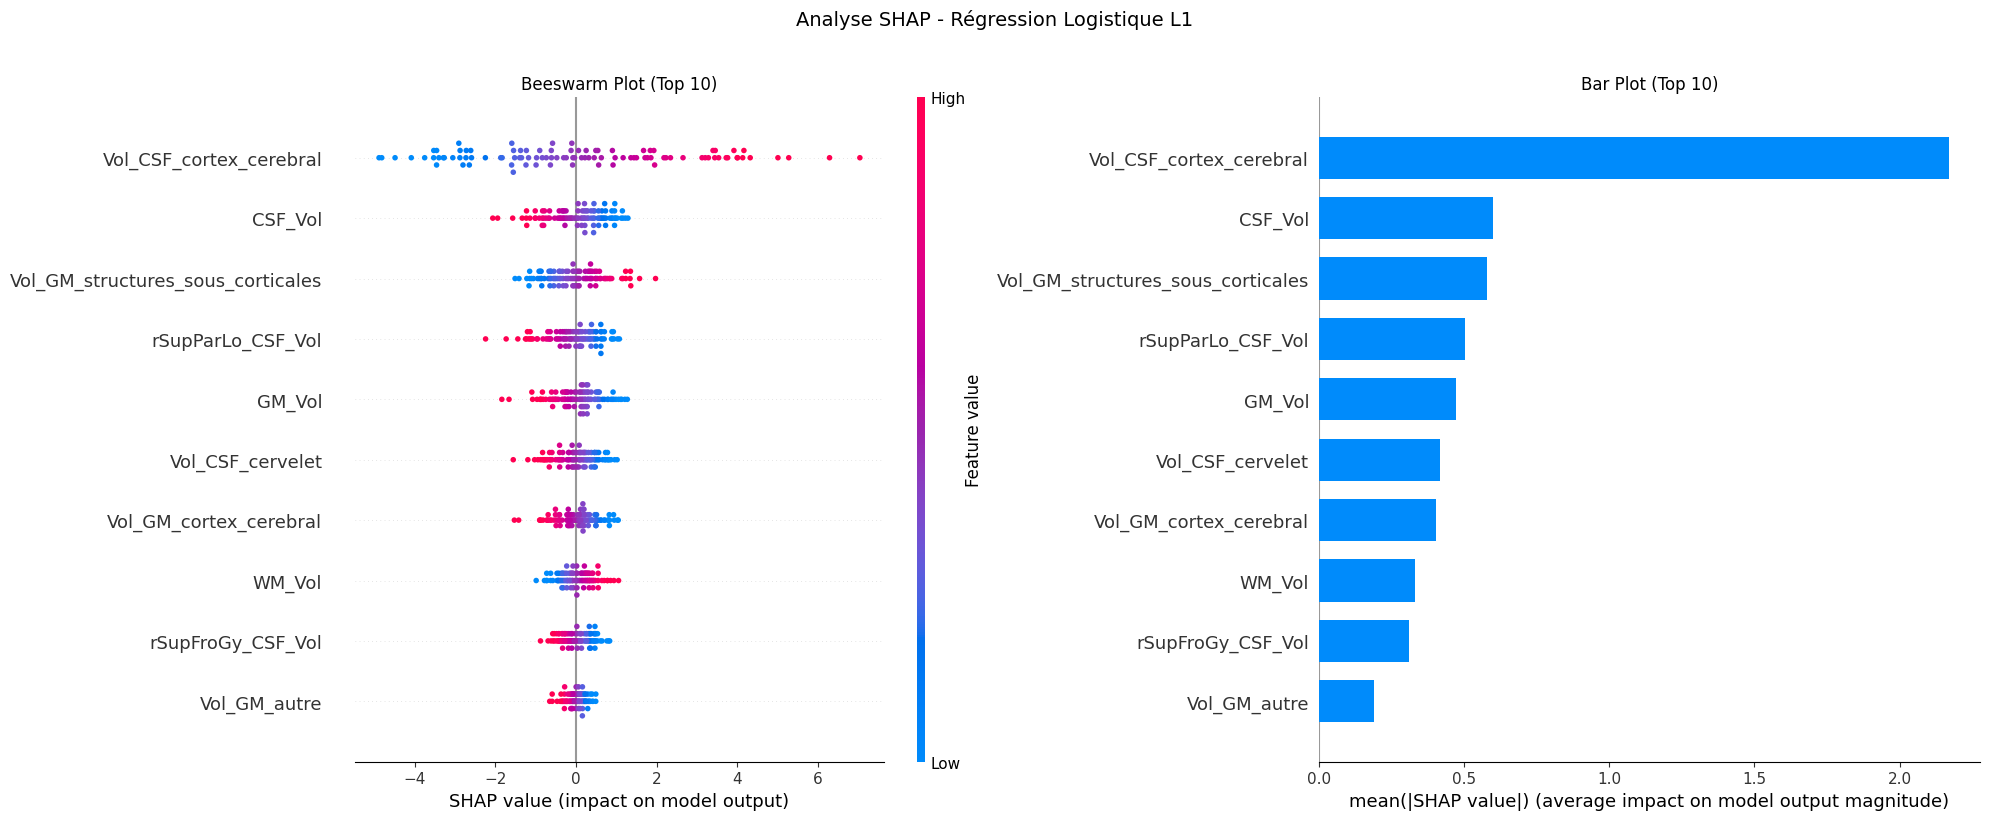


Top 20 variables importantes pour Régression Logistique L1:
[Vol_CSF_cortex_cerebral, CSF_Vol, Vol_GM_structures_sous_corticales, rSupParLo_CSF_Vol, GM_Vol, Vol_CSF_cervelet, Vol_GM_cortex_cerebral, WM_Vol, rSupFroGy_CSF_Vol, Vol_GM_autre, Vol_CSF_structures_sous_corticales, lSupParLo_CSF_Vol, rPut_GM_Vol, Vol_CSF_tronc_cerebral, rAngGy_CSF_Vol, lThaPro_GM_Vol, lSupFroGy_CSF_Vol, rThaPro_GM_Vol, lSCA_CSF_Vol, rSCA_CSF_Vol]


d:\bureau\M2 MOSEF\S1\ML\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


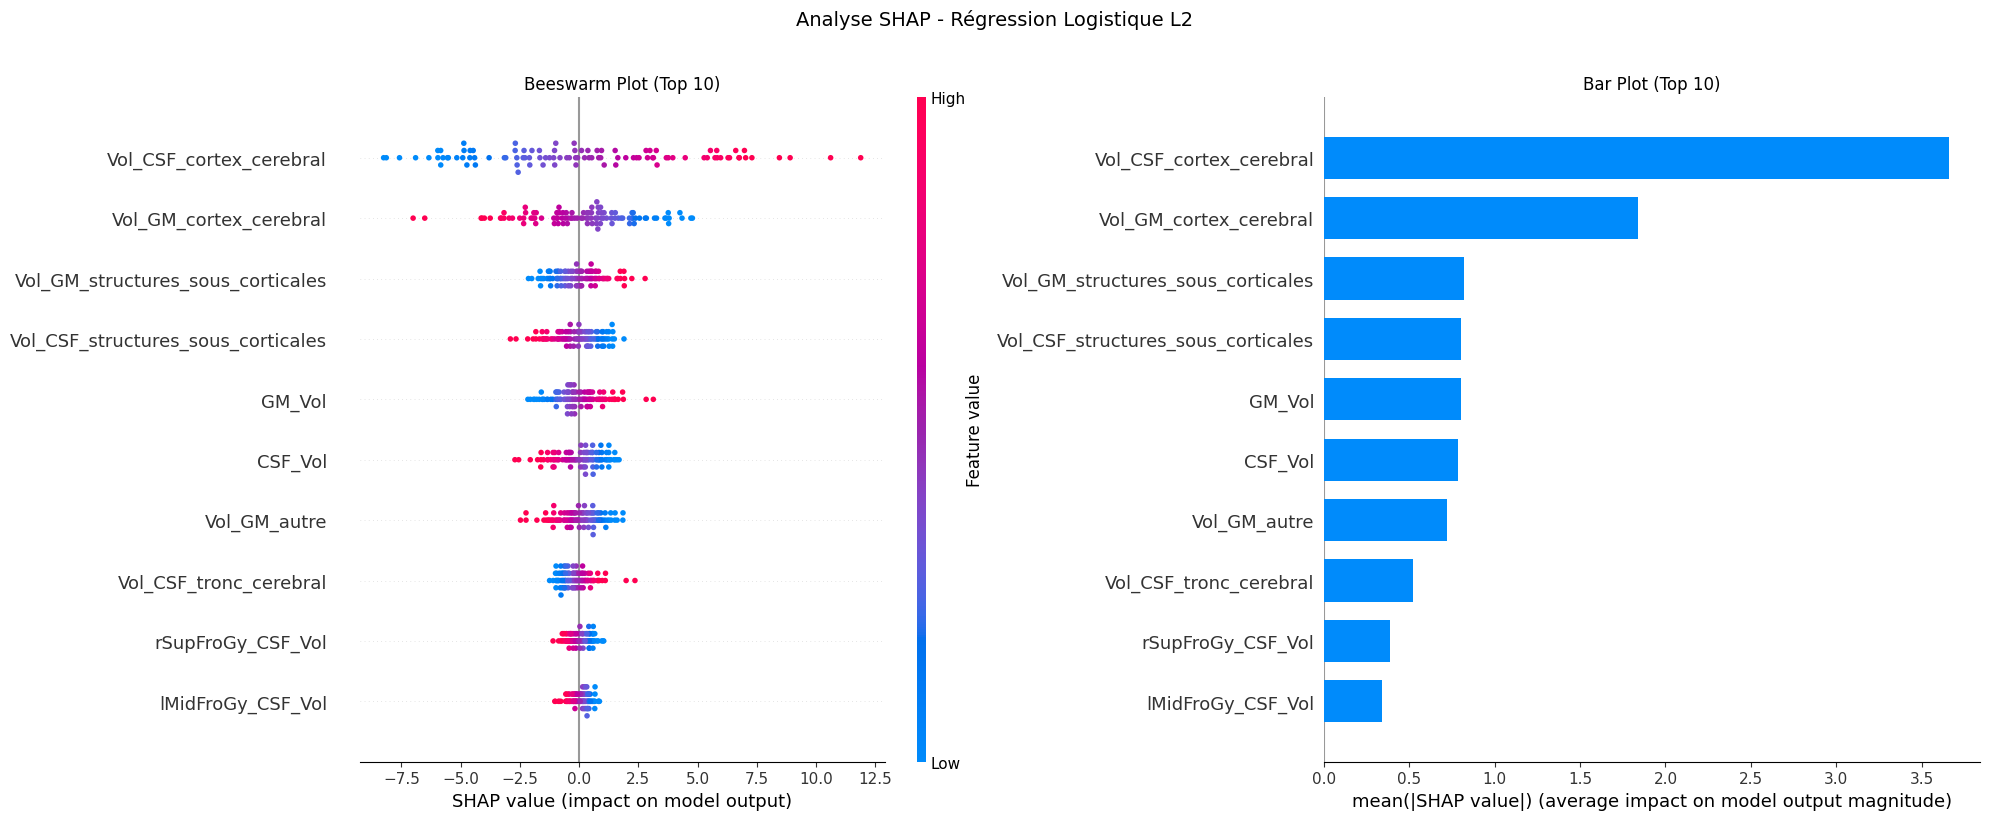


Top 20 variables importantes pour Régression Logistique L2:
[Vol_CSF_cortex_cerebral, Vol_GM_cortex_cerebral, Vol_GM_structures_sous_corticales, Vol_CSF_structures_sous_corticales, GM_Vol, CSF_Vol, Vol_GM_autre, Vol_CSF_tronc_cerebral, rSupFroGy_CSF_Vol, lMidFroGy_CSF_Vol, WM_Vol, lLatVen_CSF_Vol, rExtCbe_CSF_Vol, rSupParLo_CSF_Vol, lMidFroGy_GM_Vol, lSupFroGy_GM_Vol, rAngGy_GM_Vol, rExtCbe_GM_Vol, rInfTemGy_GM_Vol, rThaPro_GM_Vol]


d:\bureau\M2 MOSEF\S1\ML\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


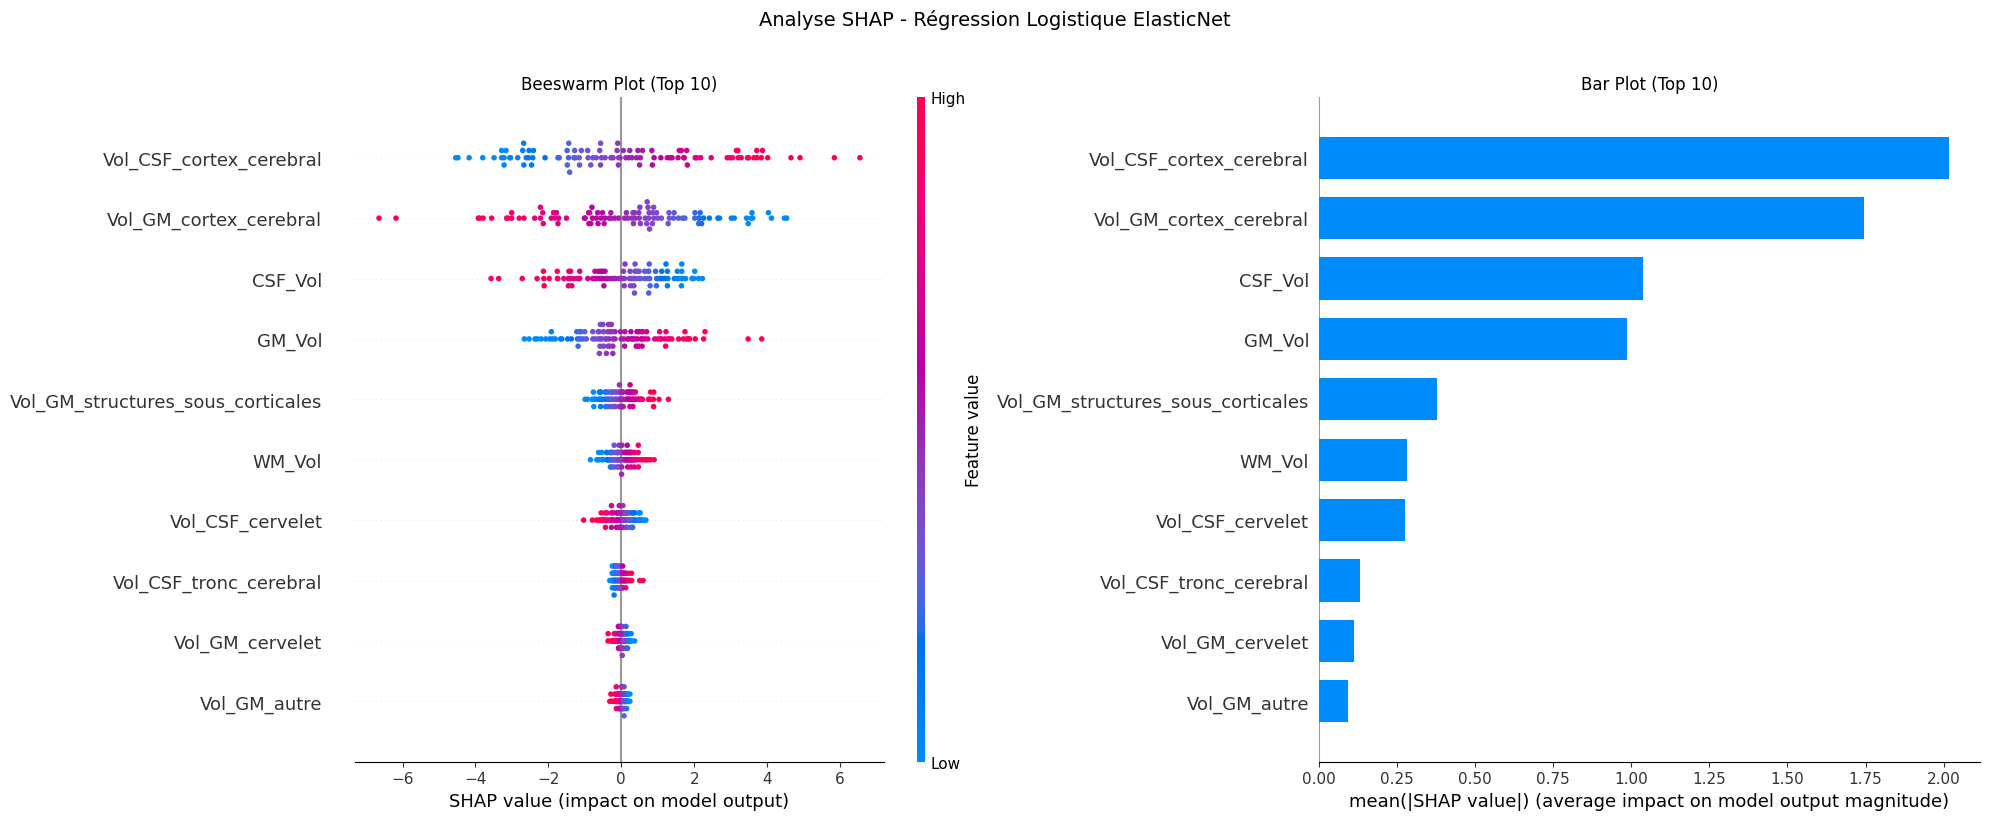


Top 20 variables importantes pour Régression Logistique ElasticNet:
[Vol_CSF_cortex_cerebral, Vol_GM_cortex_cerebral, CSF_Vol, GM_Vol, Vol_GM_structures_sous_corticales, WM_Vol, Vol_CSF_cervelet, Vol_CSF_tronc_cerebral, Vol_GM_cervelet, Vol_GM_autre, rSupParLo_CSF_Vol, rSupFroGy_CSF_Vol, lSupFroGy_CSF_Vol, lSupParLo_CSF_Vol, Vol_CSF_structures_sous_corticales, rExtCbe_CSF_Vol, lPoCGy_CSF_Vol, rPoCGy_CSF_Vol, lExtCbe_CSF_Vol, lPrcGy_CSF_Vol]


In [16]:
def create_shap_analysis(model, X_train, X_test, model_name):
    feature_names = X_test.columns.tolist()
    explainer_shap = shap.Explainer(model, X_train, model_output='probability')
    shap_values = explainer_shap(X_test[:100])
    shap_values_class1 = shap_values.values

    # Calculer les importances pour sélectionner les 10 plus importantes
    feature_importance = np.abs(shap_values_class1).mean(0)
    top_10_indices = np.argsort(feature_importance)[::-1][:10]
    top_10_features = [feature_names[i] for i in top_10_indices]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.suptitle(f"Analyse SHAP - {model_name}", fontsize=14, y=1.02)
    
    # Beeswarm Plot limité aux 10 premières variables
    plt.sca(ax1)
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        show=False,
        plot_size=None
    )
    ax1.set_title("Beeswarm Plot (Top 10)")

    # Bar Plot limité aux 10 premières variables
    plt.sca(ax2)
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        plot_type="bar",
        show=False,
        plot_size=None
    )
    ax2.set_title("Bar Plot (Top 10)")
    
    plt.tight_layout()
    plt.show()

    # Retourner les 20 premières variables (facultatif si besoin plus tard)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df['feature'].head(20).tolist()


def print_top_features(model_name, top_features):
    """
    Affiche les 20 variables importantes sous forme de liste.
    """
    print(f"\nTop 20 variables importantes pour {model_name}:")
    print(f"[{', '.join(top_features)}]")


models_params = {
    'L1': {
        'params': {
            'penalty': 'l1',
            'solver': 'liblinear',
            'C': 0.09950992842644213,
            'max_iter': 2524,
            'random_state': 42
        },
        'name': 'Régression Logistique L1'
    },
    'L2': {
        'params': {
            'penalty': 'l2',
            'solver': 'lbfgs',
            'C': 0.09835741476856286,
            'max_iter': 1642,
            'random_state': 42
        },
        'name': 'Régression Logistique L2'
    },
    'ElasticNet': {
        'params': {
            'penalty': 'elasticnet',
            'solver': 'saga',
            'C': 0.09360659956296145,
            'max_iter': 2533,
            'l1_ratio': 0.44939891537109655,
            'random_state': 42
        },
        'name': 'Régression Logistique ElasticNet'
    }
}


features_list = test_rois.columns
top_features_by_model = {}

for model_key, model_config in models_params.items():
    model = LogisticRegression(**model_config['params'])
    model.fit(train_rois[features_list], y_train)
    
    top_features = create_shap_analysis(
        model, 
        train_rois[features_list], 
        test_rois[features_list],
        model_config['name']
    )
    top_features_by_model[model_key] = top_features
    
    print_top_features(model_config['name'], top_features)


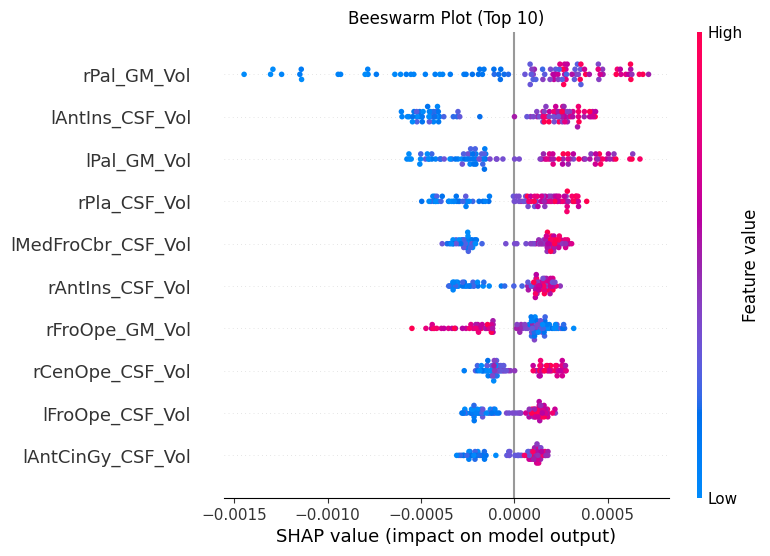

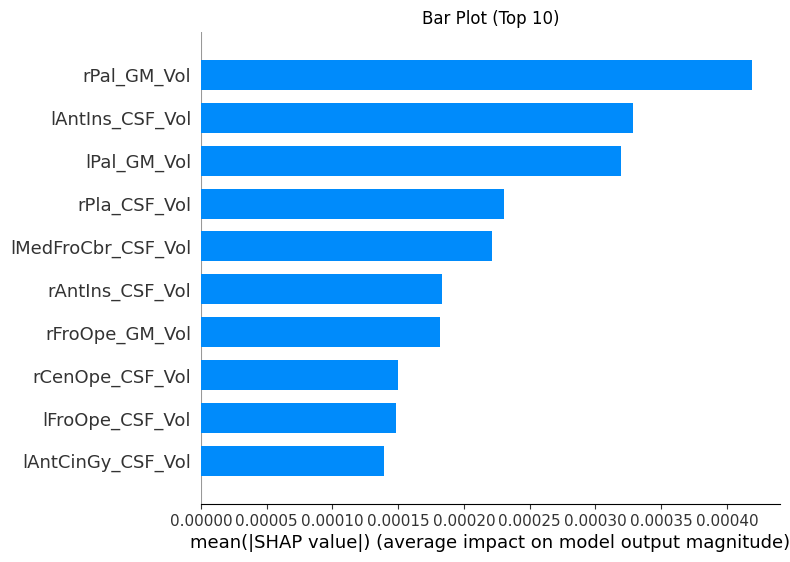


Top 20 variables importantes :
['rPal_GM_Vol', 'lAntIns_CSF_Vol', 'lPal_GM_Vol', 'rPla_CSF_Vol', 'lMedFroCbr_CSF_Vol', 'rAntIns_CSF_Vol', 'rFroOpe_GM_Vol', 'rCenOpe_CSF_Vol', 'lFroOpe_CSF_Vol', 'lAntCinGy_CSF_Vol', 'rInfLatVen_CSF_Vol', 'lHip_GM_Vol', 'rSupMedFroGy_GM_Vol', 'lPla_CSF_Vol', 'rInfFroAngGy_GM_Vol', 'lCenOpe_GM_Vol', 'rInfFroGy_GM_Vol', 'rSupTemGy_GM_Vol', 'lInfFroOrbGy_CSF_Vol', 'rMedFroCbr_CSF_Vol']


In [17]:
def create_shap_plots(model, X_test):
    feature_names = X_test.columns.tolist()

    # Créer l'explainer et calculer les valeurs SHAP
    explainer_shap = shap.TreeExplainer(model)
    shap_values = explainer_shap.shap_values(X_test[:100])

    # Vérifier si shap_values est une liste (cas multi-classes)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values

    # Calculer les importances et sélectionner les 10 plus importantes
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
    top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]
    top_10_features = [feature_names[i] for i in top_10_indices]

    # Beeswarm Plot limité aux 10 premières variables
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        show=False
    )
    plt.title("Beeswarm Plot (Top 10)")
    plt.show()

    # Bar Plot limité aux 10 premières variables
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1[:, top_10_indices],
        X_test.iloc[:100, top_10_indices],
        feature_names=top_10_features,
        plot_type="bar",
        show=False
    )
    plt.title("Bar Plot (Top 10)")
    plt.show()

    # Créer un DataFrame pour les 20 premières variables importantes
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean_ABS_SHAP": mean_abs_shap
    }).sort_values(by="Mean_ABS_SHAP", ascending=False).head(20)

    return importance_df["Feature"].tolist()


params_gbc = {
    'n_estimators': 56, 
    'learning_rate': 4.450851078458098e-05, 
    'max_depth': 4, 
    'subsample': 0.6922360672727326, 
    'min_samples_split': 15, 
    'min_samples_leaf': 8, 
    'max_features': 0.4093597867018952, 
    'random_state': 42
}

model = GradientBoostingClassifier(**params_gbc)
model.fit(train_rois[features_list], y_train)

important_features = create_shap_plots(model, test_rois[features_list])

print("\nTop 20 variables importantes :")
print(important_features)


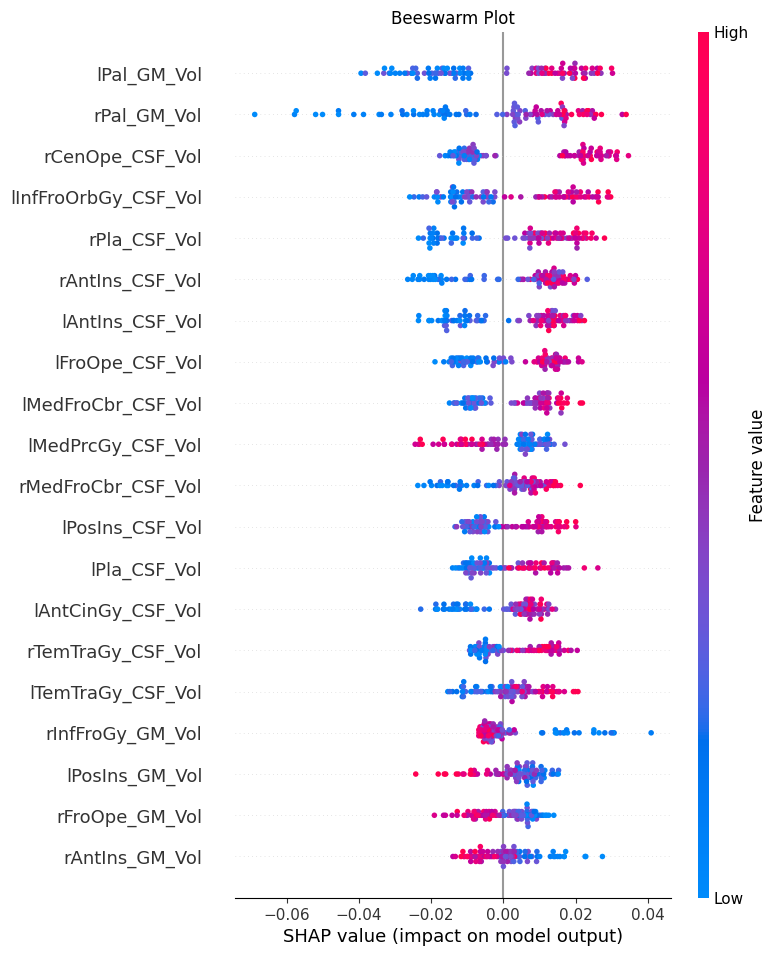

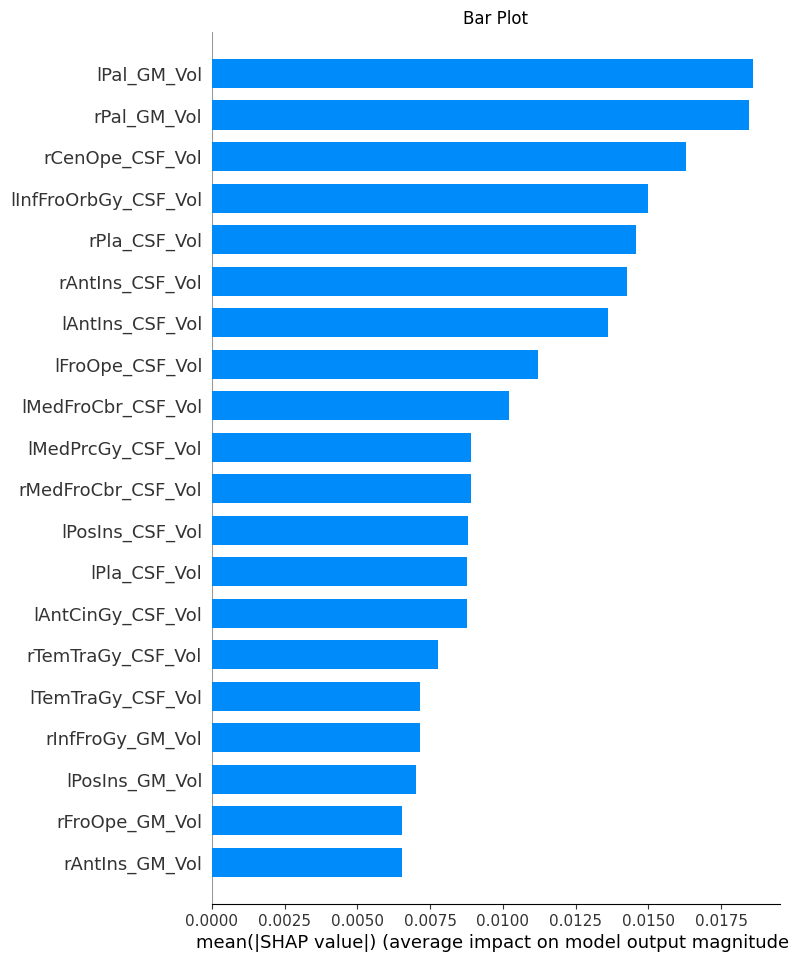

In [118]:
def create_shap_plots(model, X_train, X_test):
    feature_names = X_test.columns.tolist()

    explainer_shap = shap.TreeExplainer(model, X_train, model_output='probability')
    shap_values = explainer_shap(X_test[:100])
    
    shap_values_class1 = shap_values[:, :, 1]

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1,
        X_test[:100],
        feature_names=feature_names,
        show=False
    )
    plt.title("Beeswarm Plot")
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_class1,
        X_test[:100],
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title("Bar Plot")
    plt.show()

params_rf = {
    'n_estimators': 77,
    'max_depth': 17,
    'min_samples_split': 9,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': False,
    'random_state': 42
}


model = RandomForestClassifier(**params_rf)
model.fit(train_rois[features_list], y_train)

create_shap_plots(model, train_rois[features_list], test_rois[features_list])
